### Test loading new WH data

In [1]:
import importlib
import glob
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader, TensorDataset

import cv2
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

from Models.TABS_Model import TABS
import WHLoader as WHLoader

In [2]:
data_root_folder = '../../../data/WH_PVE_PPMI/'
imgs_dir = os.path.join(data_root_folder, 'Step0_WH_T1_MNI152rigid_iso1mm')
img_dirs = sorted(glob.glob(os.path.join(imgs_dir, '*.gz')))
print('img_dirs len:', len(img_dirs))

imgs_FAST_dir = os.path.join(data_root_folder, 'Step0_WB_T1_MNI152rigid_iso1mm_FAST_PVE')
img_FAST_dirs = sorted(glob.glob(os.path.join(imgs_FAST_dir, '*.gz')))
print('img_FAST len:', len(img_FAST_dirs))

imgs_pveseg_dir = os.path.join(data_root_folder, 'Step0_WB_T1_MNI152rigid_iso1mm_FAST_PVE/pveseg')
img_pveseg_dirs = sorted(glob.glob(os.path.join(imgs_pveseg_dir, '*.gz')))
print('img_pveseg len:', len(img_pveseg_dirs))

img_dirs len: 1414
img_FAST len: 8555
img_pveseg len: 1419


## Load a sample and see how it looks

../../../data/WH_PVE_PPMI/Step0_WH_T1_MNI152rigid_iso1mm/PPMI_100001_MR_SAG_3D_MPRAGE__br_raw_20210723152805961_91_S1047624_I1473172.nii.gz
(197, 233, 189)
(197, 233)
../../../data/WH_PVE_PPMI/Step0_WB_T1_MNI152rigid_iso1mm_FAST_PVE/PPMI_100001_MR_SAG_3D_MPRAGE__br_raw_20210723152805961_91_S1047624_I1473172_mixeltype.nii.gz
(197, 233, 189)
../../../data/WH_PVE_PPMI/Step0_WB_T1_MNI152rigid_iso1mm_FAST_PVE/PPMI_100001_MR_SAG_3D_MPRAGE__br_raw_20210723152805961_91_S1047624_I1473172_pve_0.nii.gz
(197, 233, 189)
../../../data/WH_PVE_PPMI/Step0_WB_T1_MNI152rigid_iso1mm_FAST_PVE/PPMI_100001_MR_SAG_3D_MPRAGE__br_raw_20210723152805961_91_S1047624_I1473172_pve_1.nii.gz
(197, 233, 189)
../../../data/WH_PVE_PPMI/Step0_WB_T1_MNI152rigid_iso1mm_FAST_PVE/PPMI_100001_MR_SAG_3D_MPRAGE__br_raw_20210723152805961_91_S1047624_I1473172_pve_2.nii.gz
(197, 233, 189)
../../../data/WH_PVE_PPMI/Step0_WB_T1_MNI152rigid_iso1mm_FAST_PVE/PPMI_100001_MR_SAG_3D_MPRAGE__br_raw_20210723152805961_91_S1047624_I1473172_pve

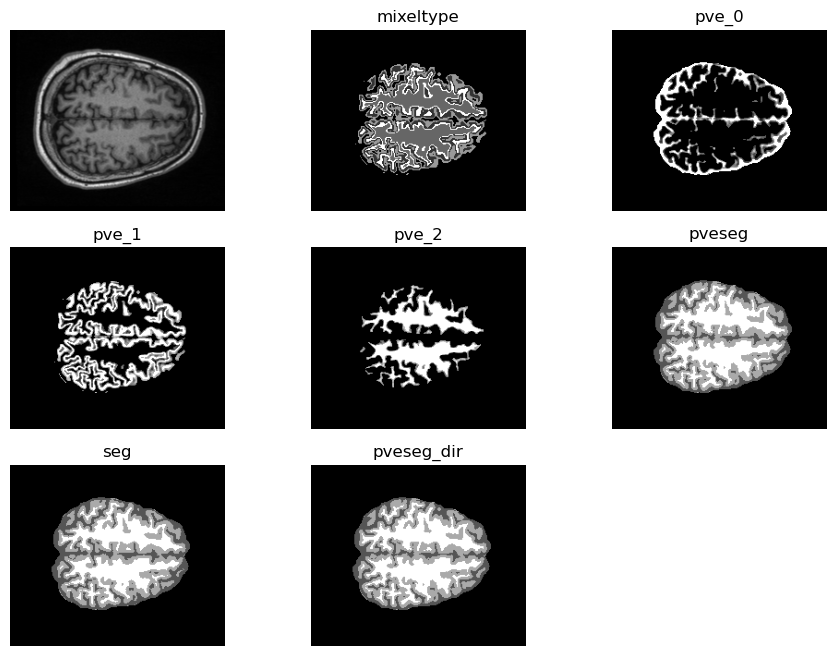

In [3]:
plt.figure(figsize=(11,8))
counter = 1
sample_slice = 120

for sample in range(1):
#     print(img_dirs[sample][img_dirs[sample].find('_FAST_PVE')+len('_FAST_PVE'):])
    print(img_dirs[sample])
    test_load = nib.load(img_dirs[sample]).get_fdata()
    print(test_load.shape)
    # print(isinstance(test_load, np.ndarray))
    test = test_load[:,:,sample_slice]
    # test = test_load[:,13:205,:]
    print(test.shape)
    plt.subplot(3,3,counter)
    counter += 1
    plt.imshow(test, cmap='gray')
    plt.axis('off')
    
# for sample in range(14):
#     print(img_FAST_dirs[sample])

names = ['mixeltype', 'pve_0', 'pve_1', 'pve_2', 'pveseg', 'seg']

for sample in range(6):
    test_load = nib.load(img_FAST_dirs[sample]).get_fdata()
    print(img_FAST_dirs[sample])
    print(test_load.shape)
    # print(isinstance(test_load, np.ndarray))
    test = test_load[:,:,sample_slice]
    plt.subplot(3,3,counter)
    counter += 1
    plt.imshow(test, cmap='gray')
    plt.title(names[sample])
    plt.axis('off')
    
test_load = nib.load(img_pveseg_dirs[0]).get_fdata()
print(img_pveseg_dirs[0])
print(test_load.shape)
# print(isinstance(test_load, np.ndarray))
test = test_load[:,:,sample_slice]
plt.subplot(3,3,counter)
counter += 1
plt.imshow(test, cmap='gray')
plt.axis('off')
plt.title('pveseg_dir')
    
plt.show()

## Find out how different the image, grouth truth, and ground truth pvesvg are

In [4]:
files = []
files_FAST = []
files_pveseg = []

with open('img_dirs.txt', 'w') as f:
    for i in range(len(img_dirs)):
        img_dir = img_dirs[i] 
        # write to file
        f.write(img_dir + '\n')

        cut_start = '_iso1mm'
        cut_end = '.nii.gz'
        idx_start = img_dir.index(cut_start)
        idx_end = img_dir.index(cut_end)
        img_dir = img_dir[idx_start + len(cut_start) + 1:idx_end]

        files.append(img_dir)
        # print(img_dir)

with open('img_FAST_dirs.txt', 'w') as f:
    
    for sample in range(len(img_FAST_dirs)):
        test = img_FAST_dirs[sample]
        # print(sample)
        # print(test)
        f.write(test + '\n')

        cut_start = '_FAST_PVE'
        idx_start = test.index(cut_start)
        cut_ends = ['_mixeltype', '_pve', '_seg']

        for c in cut_ends:
            if test.find(c) != -1:
                cut_end = c
                break
            assert c != cut_ends[len(cut_ends)-1], 'found errors in ' + str(sample)
        idx_end = test.index(cut_end)

        test = test[idx_start + len(cut_start) + 1:idx_end]
        files_FAST.append(test)
        # print(test)

for i in range(len(img_pveseg_dirs)):
    img_dir = img_pveseg_dirs[i]
    img_dir = img_dir[img_dir.index('pveseg')+len('pveseg')+1:img_dir.index('_pveseg')]
    
    files_pveseg.append(img_dir)
#     print(img_dir)
#     break

print('files len:', len(files))
print('files_FAST len:', len(files_FAST))
print('files_pveseg len:', len(files_pveseg))

# After unique
print()
print('After unique----\n')

files = set(files)
files_FAST = set(files_FAST)
files_pveseg = set(files_pveseg)

print('files len:', len(files))
print('files_FAST len:', len(files_FAST))
print('files_pveseg len:', len(files_pveseg))

print('Are files and files_FAST the same?', files == files_FAST)
print('Are files_FAST and files_pveseg the same?', files_FAST == files_pveseg)
print()

# How different 
print('What are the files not in files_FAST or files_pveseg?\n')

files_not_in = []
for file in files:
    if file not in files_FAST:
        print(file)
        files_not_in.append(file)
        
for file in files_not_in:
    files.remove(file)

print()
print('files after remove:', len(files))
print('Do files and files_FAST equal?', files == files_FAST)

files len: 1414
files_FAST len: 8555
files_pveseg len: 1419

After unique----

files len: 1414
files_FAST len: 1409
files_pveseg len: 1409
Are files and files_FAST the same? False
Are files_FAST and files_pveseg the same? True

What are the files not in files_FAST or files_pveseg?

PPMI_172854_MR_3D_T1-weighted_br_raw_20221120180904779_135_S1177180_I1643731
PPMI_75414_MR_Sag_MPRAGE_GRAPPA__br_raw_20190213160046084_113_S796621_I1130191
PPMI_3116_MR_MPRAGE_GRAPPA__br_raw_20140319120536400_79_S214312_I417050
PPMI_141714_MR_3D_T1__br_raw_20220826213915385_55_S1156221_I1616839
PPMI_101124_MR_3D_T1-weighted_br_raw_20220524171424708_1_S1136025_I1583926

files after remove: 1409
Do files and files_FAST equal? True


## Create train test split before feeding to WHLoader

In [5]:
importlib.reload(WHLoader)

files = list(files)

# Train test valid split
files_train, files_test = train_test_split(files, test_size=0.2, shuffle=True)
files_train, files_valid = train_test_split(files_train, test_size=0.2, shuffle=True)
print('files_train len:', len(files_train))
print('files_valid len:', len(files_valid))
print('files_test len:', len(files_test))

train_dataset = WHLoader.WHDataset(files_train)
valid_dataset = WHLoader.WHDataset(files_valid)
test_dataset = WHLoader.WHDataset(files_test)

train_dataloader = DataLoader(train_dataset, batch_size=3, shuffle=True, num_workers=2, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=3, num_workers=2, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=2, num_workers=2, pin_memory=True)

files_train len: 901
files_valid len: 226
files_test len: 282


### Test if dataloader is working

Sample num: 0
x shape is torch.Size([1, 192, 192, 192])
y shape is torch.Size([3, 192, 192, 192])


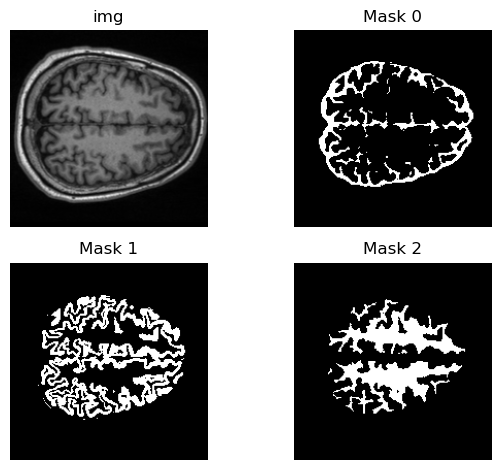

In [6]:
# sample = np.random.randint(0, len(train_dataset))
sample = 0
print('Sample num:', sample)
data = train_dataset.__getitem__(sample)
x = data['image']
y = data['mask']

print(f'x shape is {x.shape}')
print(f'y shape is {y.shape}')

plt.subplot(2,2,1)
plt.imshow(x[0,:,:,120], cmap='gray')
plt.axis('off')
plt.title('img')

plt.subplot(2,2,2)
plt.imshow(y[0,:,:,120], cmap='gray')
plt.axis('off')
plt.title('Mask 0')

plt.subplot(2,2,3)
plt.imshow(y[1,:,:,120], cmap='gray')
plt.axis('off')
plt.title('Mask 1')

plt.subplot(2,2,4)
plt.imshow(y[2,:,:,120], cmap='gray')
plt.axis('off')
plt.title('Mask 2')

plt.tight_layout()
plt.show()

../data/WH_PVE_PPMI/Step0_WH_T1_MNI152rigid_iso1mm/PPMI_100001_MR_SAG_3D_MPRAGE__br_raw_20210723152805961_91_S1047624_I1473172.nii.gz
(197, 233, 189)
../data/WH_PVE_PPMI/Step0_WB_T1_MNI152rigid_iso1mm_FAST_PVE/PPMI_100001_MR_SAG_3D_MPRAGE__br_raw_20210723152805961_91_S1047624_I1473172_pve_0.nii.gz
(197, 233, 189)
../data/WH_PVE_PPMI/Step0_WB_T1_MNI152rigid_iso1mm_FAST_PVE/PPMI_100001_MR_SAG_3D_MPRAGE__br_raw_20210723152805961_91_S1047624_I1473172_pve_1.nii.gz
(197, 233, 189)
../data/WH_PVE_PPMI/Step0_WB_T1_MNI152rigid_iso1mm_FAST_PVE/PPMI_100001_MR_SAG_3D_MPRAGE__br_raw_20210723152805961_91_S1047624_I1473172_pve_2.nii.gz
(197, 233, 189)
../data/WH_PVE_PPMI/Step0_WB_T1_MNI152rigid_iso1mm_FAST_PVE/PPMI_100001_MR_SAG_3D_MPRAGE__br_raw_20210723152805961_91_S1047624_I1473172_pveseg.nii.gz
(197, 233, 189)
../data/WH_PVE_PPMI/Step0_WB_T1_MNI152rigid_iso1mm_FAST_PVE/PPMI_100001_MR_SAG_3D_MPRAGE__br_raw_20210723152805961_91_S1047624_I1473172_seg.nii.gz
(197, 233, 189)
../data/WH_PVE_PPMI/Step0_

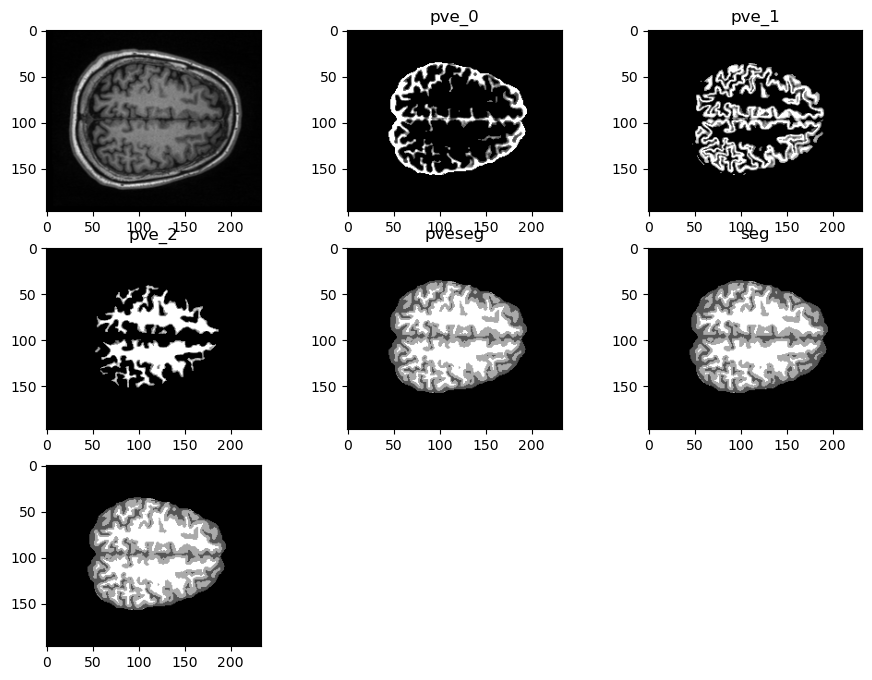

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0

In [93]:
## Don't run this anymore
## test pveseg (if they are equal) and does pve0 + pve1 + pve2 = pveseg
plt.figure(figsize=(11,8))
counter = 1

# Load original
sample = 0
print(img_dirs[sample])
test_load = nib.load(img_dirs[sample]).get_fdata()
print(test_load.shape)
# print(isinstance(test_load, np.ndarray))
origin = test_load[:,:,120]
# test = test_load[:,13:205,:]
# print(test.shape)
plt.subplot(3,3,counter)
counter += 1
plt.imshow(origin, cmap='gray')
    
# names = ['mixeltype', 'pve_0', 'pve_1', 'pve_2', 'pveseg', 'seg']

# Load fast_pve_0
sample = 1
fast_pve_0 = nib.load(img_FAST_dirs[sample]).get_fdata()
print(img_FAST_dirs[sample])
print(fast_pve_0.shape)
# print(isinstance(test_load, np.ndarray))
fast_pve_0_slice = fast_pve_0[:,:,120]
# test = test_load[:,13:205,:]
# print(test.shape)
plt.subplot(3,3,counter)
counter += 1
plt.imshow(fast_pve_0_slice, cmap='gray')
plt.title(names[sample])

# Load fast_pve_1
sample = 2
fast_pve_1 = nib.load(img_FAST_dirs[sample]).get_fdata()
print(img_FAST_dirs[sample])
print(fast_pve_1.shape)
# print(isinstance(test_load, np.ndarray))
fast_pve_1_slice = fast_pve_1[:,:,120]
# test = test_load[:,13:205,:]
# print(test.shape)
plt.subplot(3,3,counter)
counter += 1
plt.imshow(fast_pve_1_slice, cmap='gray')
plt.title(names[sample])

# Load fast_pve_2
sample = 3
fast_pve_2 = nib.load(img_FAST_dirs[sample]).get_fdata()
print(img_FAST_dirs[sample])
print(fast_pve_2.shape)
# print(isinstance(test_load, np.ndarray))
fast_pve_2_slice = fast_pve_2[:,:,120]
# test = test_load[:,13:205,:]
# print(test.shape)
plt.subplot(3,3,counter)
counter += 1
plt.imshow(fast_pve_2_slice, cmap='gray')
plt.title(names[sample])

# Load fast_pveseg
sample = 4
fast_pveseg = nib.load(img_FAST_dirs[sample]).get_fdata()
print(img_FAST_dirs[sample])
print(fast_pveseg.shape)
# print(isinstance(test_load, np.ndarray))
fast_pveseg_slice = fast_pveseg[:,:,120]
# test = test_load[:,13:205,:]
# print(test.shape)
plt.subplot(3,3,counter)
counter += 1
plt.imshow(fast_pveseg_slice, cmap='gray')
plt.title(names[sample])

# Load fast_seg
sample = 5
fast_seg = nib.load(img_FAST_dirs[sample]).get_fdata()
print(img_FAST_dirs[sample])
print(fast_seg.shape)
# print(isinstance(test_load, np.ndarray))
fast_seg_slice = fast_seg[:,:,120]
# test = test_load[:,13:205,:]
# print(test.shape)
plt.subplot(3,3,counter)
counter += 1
plt.imshow(fast_seg_slice, cmap='gray')
plt.title(names[sample])

# Load pveseg
pveseg = nib.load(img_pveseg_dirs[0]).get_fdata()
print(img_pveseg_dirs[0])
print(pveseg.shape)
# print(isinstance(test_load, np.ndarray))
pveseg_slice = pveseg[:,:,120]
# test = test_load[:,13:205,:]
# print(pveseg.shape)
plt.subplot(3,3,counter)
counter += 1
plt.imshow(pveseg_slice, cmap='gray')
plt.title('')
    
plt.show()

# Test if fast_pveseg and pveseg are the same
diff = fast_pveseg - pveseg
print(sum(sum(diff))) # all zeros so they are the same

# Test if fast_pveseg and fast_seg are the same
diff2 = fast_pveseg - fast_seg
print(diff2[100:110,100:110,120]) # they are not

# Investigate pve_0, pve_1, pve_2, and pveseg
print((fast_pve_0_slice[100:110,100:110] > 0.5) * 1.0)
print((fast_pve_1_slice[100:110,100:110] > 0.5) * 2.0)
print((fast_pve_2_slice[100:110,100:110] > 0.5) * 3.0)
print(fast_pveseg_slice[100:110,100:110])
print(fast_seg_slice[100:110,100:110])
fast_pve_0_bin = (fast_pve_0 > 0.5) * 1.0
fast_pve_1_bin = (fast_pve_1 > 0.5) * 2.0
fast_pve_2_bin = (fast_pve_2 > 0.5) * 3.0
fast_pve_sum = fast_pve_0_bin + fast_pve_1_bin + fast_pve_2_bin
diff3 = fast_pveseg - fast_pve_sum
print(sum(sum(sum(diff3)))) # it is zero so they are the same

## Test out if model works out

dict_keys(['epoch', 'state_dict', 'optim_dict'])
99
0
Batch size: 3
Batch image shape: torch.Size([3, 1, 192, 192, 192])


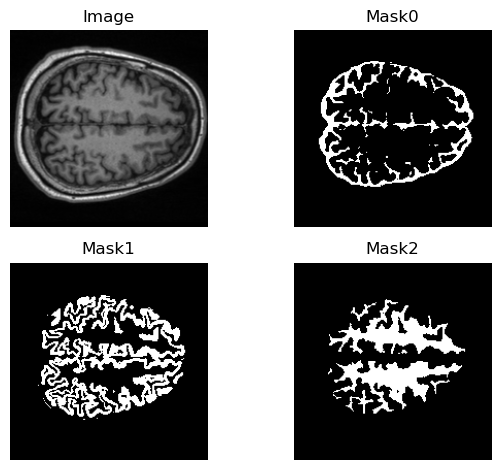

Output shape: torch.Size([3, 3, 192, 192, 192])


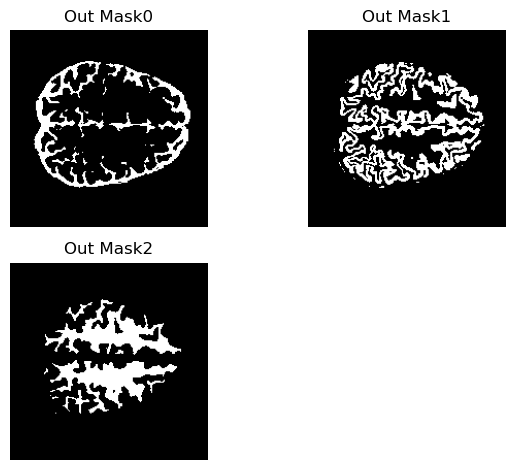

Output shape: torch.Size([3, 3, 192, 192, 192])


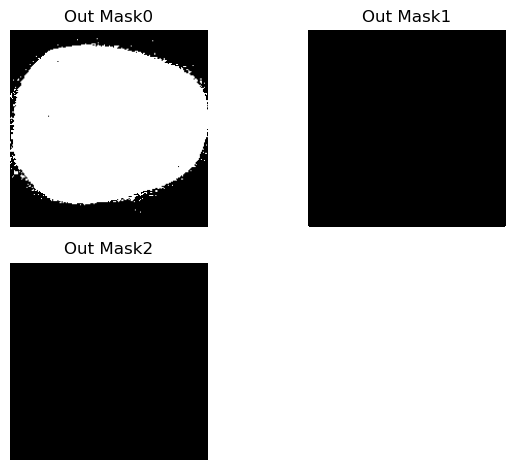

In [7]:
torch.manual_seed(1000)
torch.cuda.manual_seed(1000)
random.seed(1000)
np.random.seed(1000)

tabs = TABS()
tabs_pre_trained = TABS()

load_model = './Results/Run_4/TABS_model_epoch_99_val_loss_0.09232506881418981.pth'
checkpoint = torch.load(load_model)
print(checkpoint.keys())
print(checkpoint['epoch'])
tabs.load_state_dict(checkpoint['state_dict'])
tabs.cuda()
tabs_pre_trained.cuda()

with torch.no_grad():
    for i, batch in enumerate(train_dataloader):
        print(i)
        
        imgs = batch['image'].cuda()
        masks = batch['mask'].cuda()
        
        # Show the batch picture
        print('Batch size:', len(imgs))
        print('Batch image shape:', imgs.shape)
        
        slice_num = 120
        img = imgs[0][0].cpu()
        img_slice = img[:,:,slice_num].cpu()
        mask0 = masks[0][0]
        mask0_slice = mask0[:,:,slice_num].cpu()
        mask1 = masks[0][1]
        mask1_slice = mask1[:,:,slice_num].cpu()
        mask2 = masks[0][2]
        mask2_slice = mask2[:,:,slice_num].cpu()
        
        plt.subplot(2, 2, 1)
        plt.title('Image')
        plt.imshow(img_slice, cmap='gray')
        plt.axis('off')
        plt.subplot(2, 2, 2)
        plt.title('Mask0')
        plt.imshow(mask0_slice, cmap='gray')
        plt.axis('off')
        plt.subplot(2, 2, 3)
        plt.title('Mask1')
        plt.imshow(mask1_slice, cmap='gray')
        plt.axis('off')
        plt.subplot(2, 2, 4)
        plt.title('Mask2')
        plt.imshow(mask2_slice, cmap='gray')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        out = tabs(imgs)
        print('Output shape:', out.shape)
        
        out_mask0 = out[0][0]
        out_mask0_slice = out_mask0[:,:,slice_num].cpu().numpy()
        out_mask1 = out[0][1]
        out_mask1_slice = out_mask1[:,:,slice_num].cpu().numpy()
        out_mask2 = out[0][2]
        out_mask2_slice = out_mask2[:,:,slice_num].cpu().numpy()
        
        out_mask0_slice[out_mask0_slice <= 0.5] = 0.0
        out_mask0_slice[out_mask0_slice > 0.5] = 1.0
        out_mask1_slice[out_mask1_slice <= 0.5] = 0.0
        out_mask1_slice[out_mask1_slice > 0.5] = 1.0
        out_mask2_slice[out_mask2_slice <= 0.5] = 0.0
        out_mask2_slice[out_mask2_slice > 0.5] = 1.0
        
        plt.subplot(2, 2, 1)
        plt.title('Out Mask0')
        plt.imshow(out_mask0_slice, cmap='gray')
        plt.axis('off')
        plt.subplot(2, 2, 2)
        plt.title('Out Mask1')
        plt.imshow(out_mask1_slice, cmap='gray')
        plt.axis('off')
        plt.subplot(2, 2, 3)
        plt.title('Out Mask2')
        plt.imshow(out_mask2_slice, cmap='gray')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
#         print(out_mask0_slice[120,:])
        
        out_pre = tabs_pre_trained(imgs)
        print('Output shape:', out_pre.shape)
        
        out_mask0 = out_pre[0][0]
        out_mask0_slice = out_mask0[:,:,slice_num].cpu().numpy()
        out_mask1 = out_pre[0][1]
        out_mask1_slice = out_mask1[:,:,slice_num].cpu().numpy()
        out_mask2 = out_pre[0][2]
        out_mask2_slice = out_mask2[:,:,slice_num].cpu().numpy()
        
        out_mask0_slice[out_mask0_slice <= 0.5] = 0.0
        out_mask0_slice[out_mask0_slice > 0.5] = 1.0
        out_mask1_slice[out_mask1_slice <= 0.5] = 0.0
        out_mask1_slice[out_mask1_slice > 0.5] = 1.0
        out_mask2_slice[out_mask2_slice <= 0.5] = 0.0
        out_mask2_slice[out_mask2_slice > 0.5] = 1.0
        
        plt.subplot(2, 2, 1)
        plt.title('Out Mask0')
        plt.imshow(out_mask0_slice, cmap='gray')
        plt.axis('off')
        plt.subplot(2, 2, 2)
        plt.title('Out Mask1')
        plt.imshow(out_mask1_slice, cmap='gray')
        plt.axis('off')
        plt.subplot(2, 2, 3)
        plt.title('Out Mask2')
        plt.imshow(out_mask2_slice, cmap='gray')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        break
        # print(len(batch))
        # print(len(batch['image']))
        # Load a batch and pass it to the GPU
        # imgs = batch['image'].cuda()
        # true_masks = batch['mask'].cuda()